In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [3]:
# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%%R
#todos los dialogos completos con uniqW
dftotal = read.csv('/gdrive/My Drive/df_diccs_parametros_uniqW.csv')

In [5]:
%%R
dfinterpolado_r=dftotal[, c("id","uniqWeight","dialog_id","sender_class")]

In [6]:
%%R
head(dfinterpolado_r)

  id uniqWeight dialog_id sender_class
1  0  0.1799952 179537680          Bot
2  1  0.1838991 179537680        Human
3  2  0.1073815 179537680          Bot
4  3  0.1099677 179537680        Human
5  4  0.1524544 179537680          Bot
6  5  0.2026073 179537680        Human


In [7]:
%%R
list_d=unique(dfinterpolado_r[c("dialog_id")])

In [8]:
%%R
list_dialog=list_d$dialog_id

In [9]:
%%R

Ndiag = length(list_dialog)
print(paste('Ndiag =',Ndiag))


[1] "Ndiag = 3495"


[1] "Dialogo numero : 103"
    id uniqWeight  dialog_id sender_class
537  0  0.2718434 1762979943          Bot
539  2  0.5575000 1762979943          Bot
541  4  0.3314286 1762979943          Bot
543  6  0.3314286 1762979943          Bot
545  8  0.2202941 1762979943          Bot
547 10  0.4175000 1762979943          Bot
549 12  0.3314286 1762979943          Bot
[1] "N = 7"
[1] "Dialogo numero : 103"
    id uniqWeight  dialog_id sender_class
538  1  0.2529167 1762979943        Human
540  3  0.1762500 1762979943        Human
542  5  0.1762500 1762979943        Human
544  7  0.1762500 1762979943        Human
546  9  0.4173775 1762979943        Human
548 11  0.1762500 1762979943        Human
[1] "N = 6"
[1] "Dialogo numero : 105"
    id uniqWeight dialog_id sender_class
551  0  0.4292672  64326391          Bot
553  2  0.3491397  64326391          Bot
[1] "N = 2"
[1] "Dialogo numero : 107"
    id uniqWeight  dialog_id sender_class
555  0          3 1288001678        Human
556  1          3 1

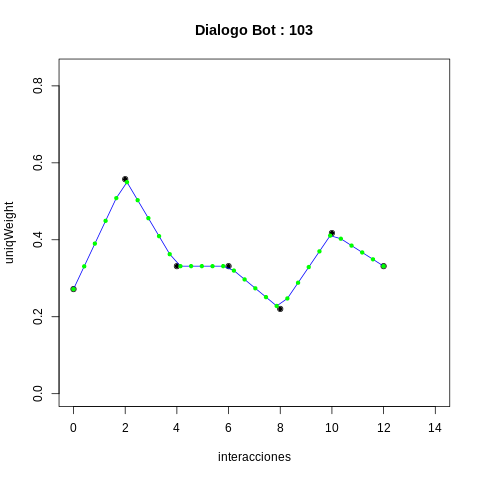

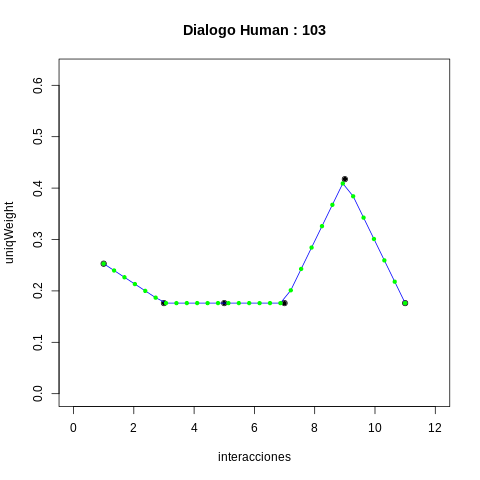

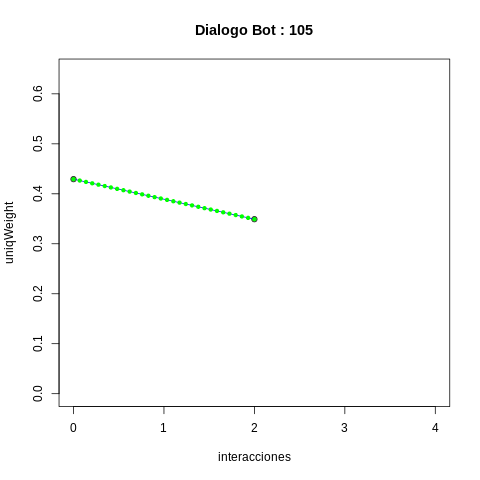

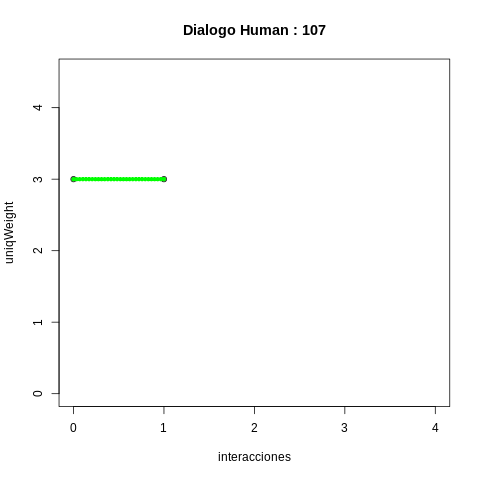

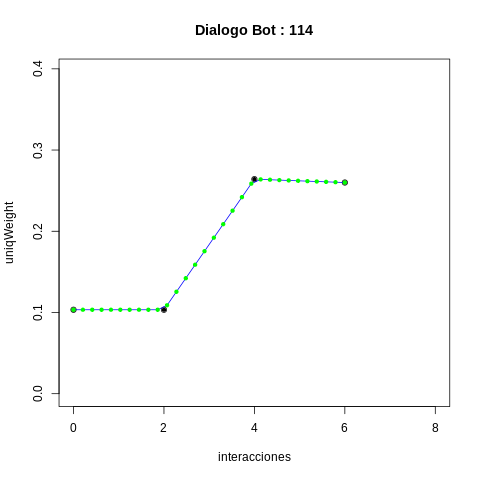

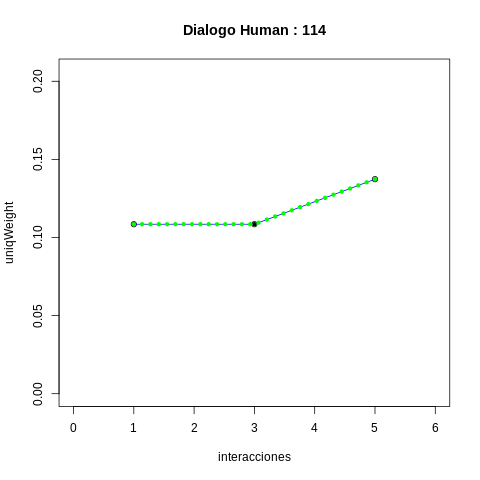

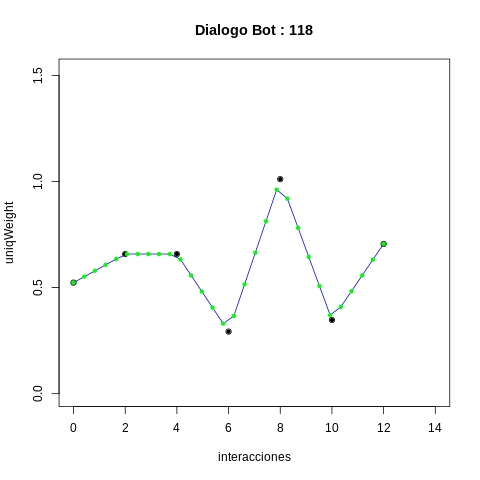

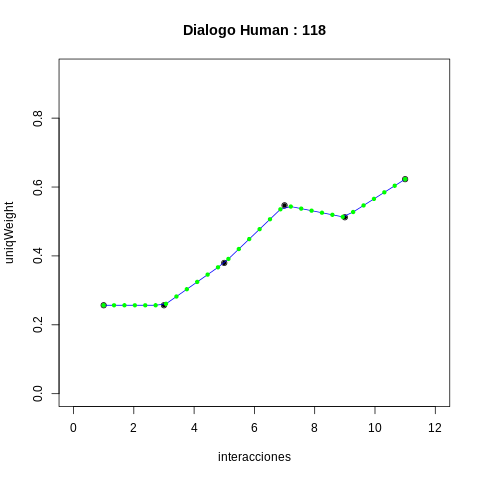

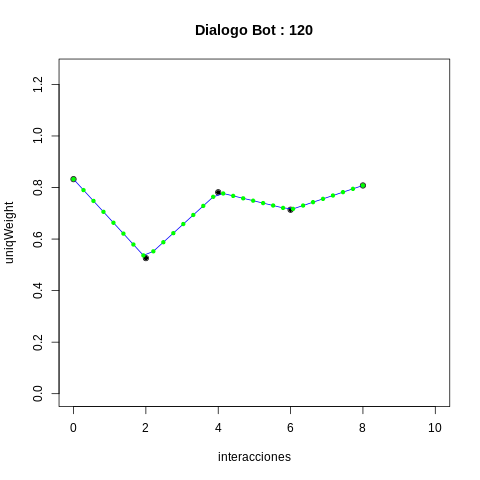

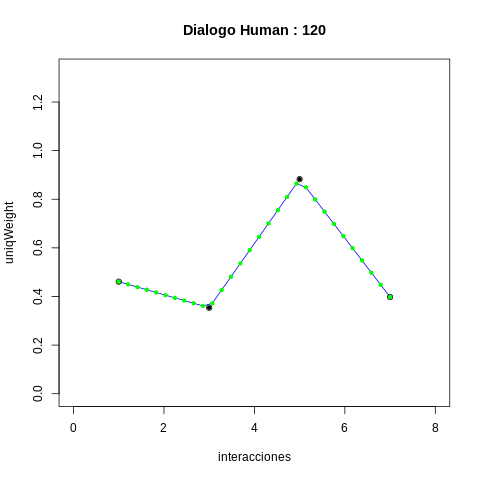

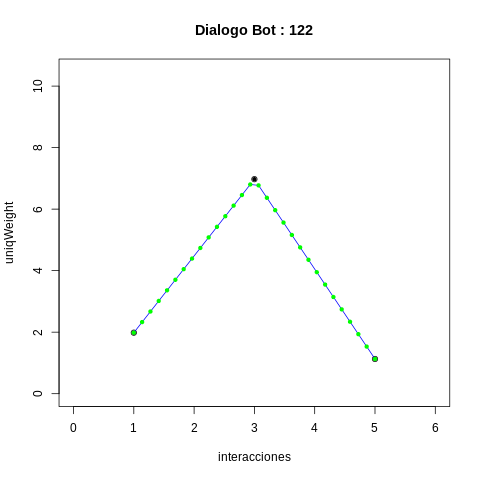

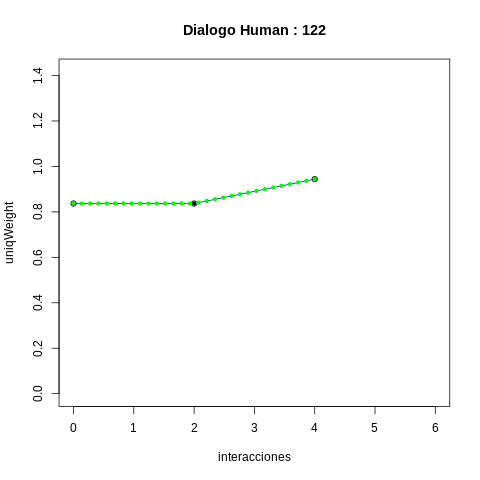

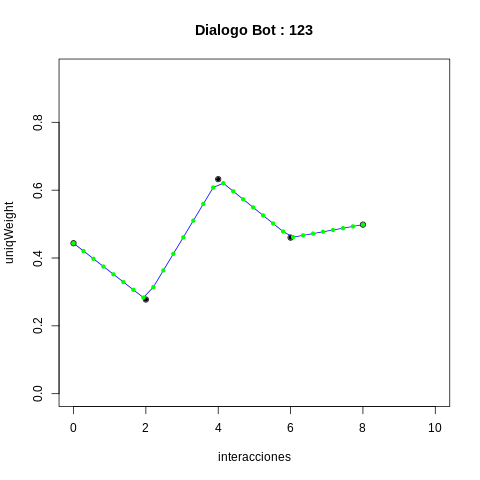

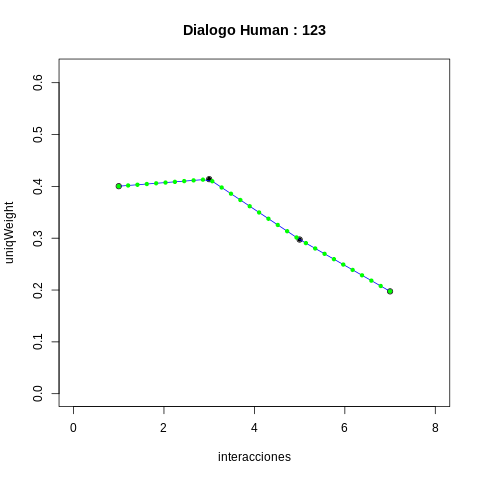

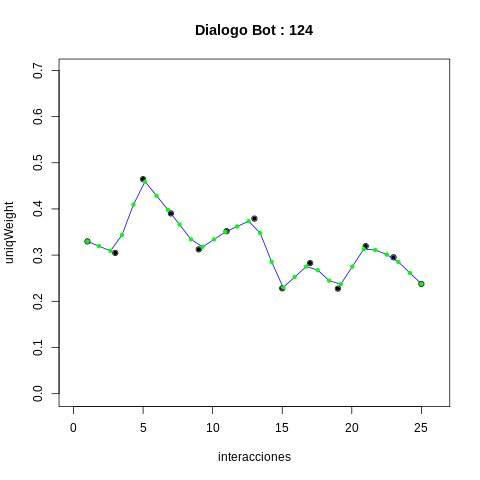

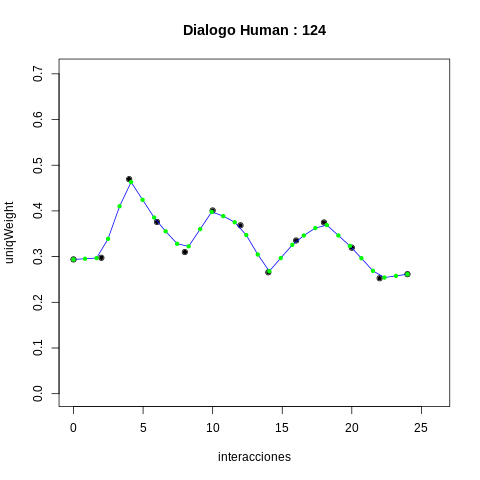

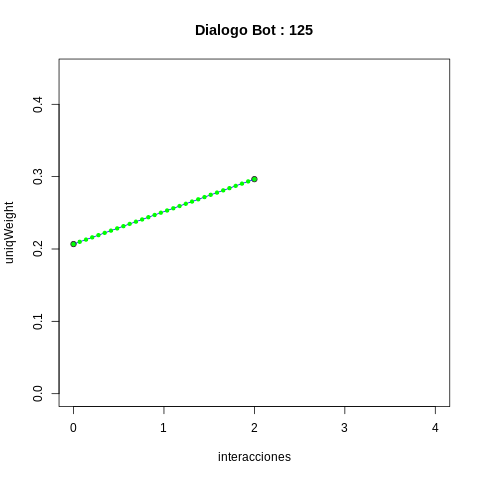

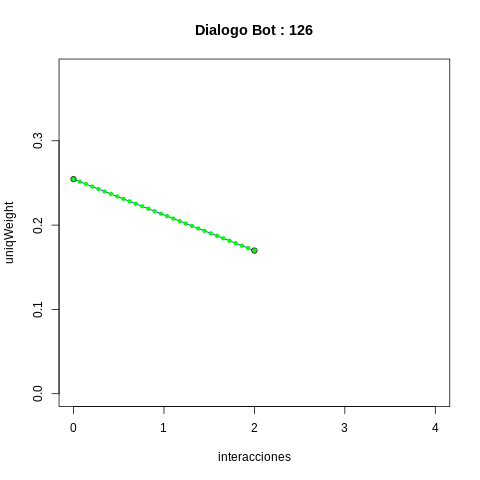

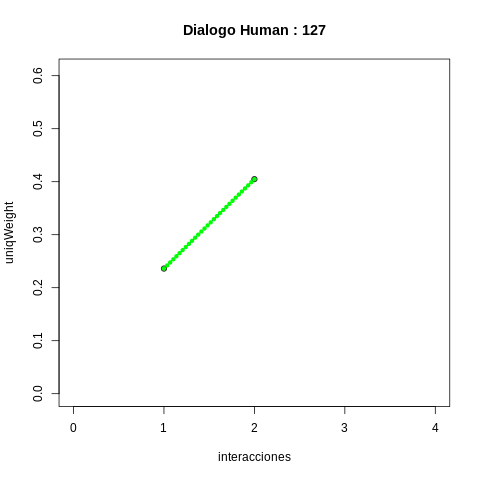

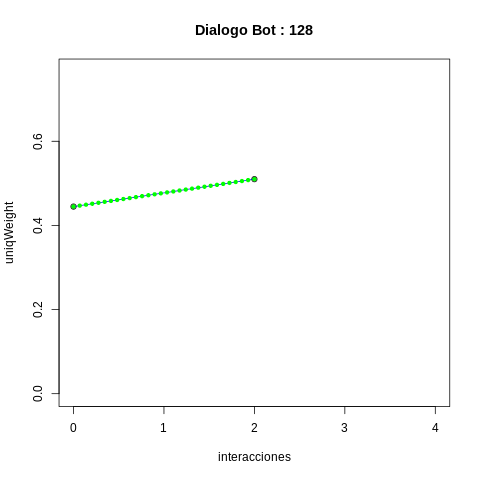

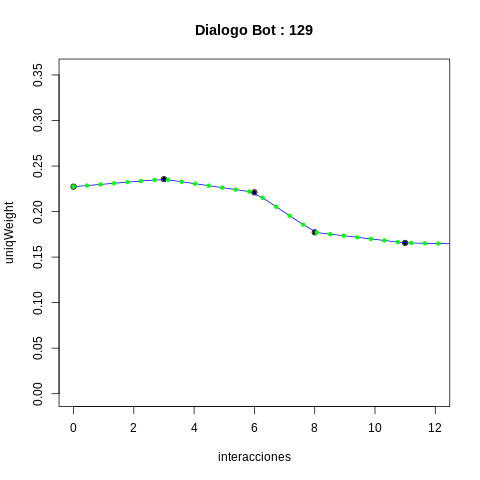

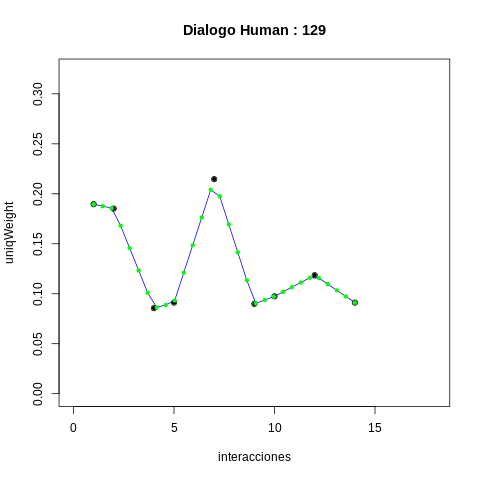

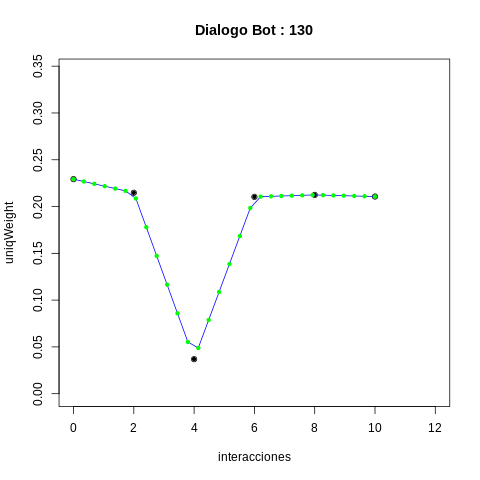

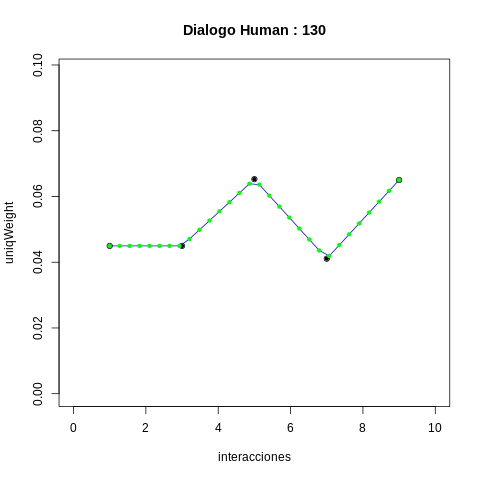

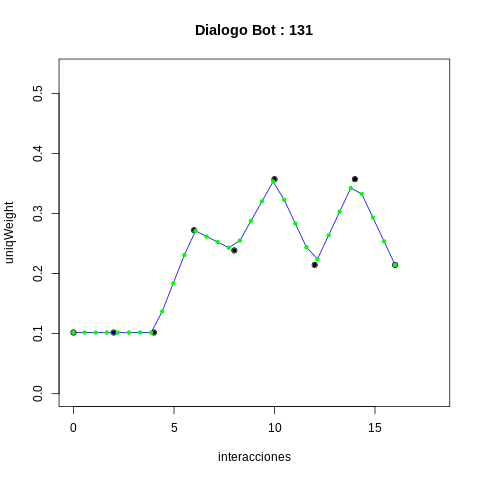

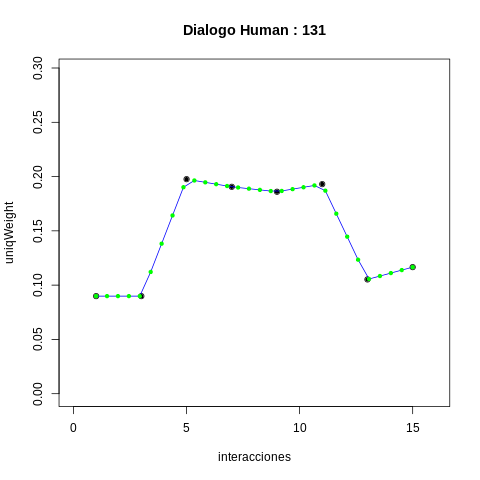

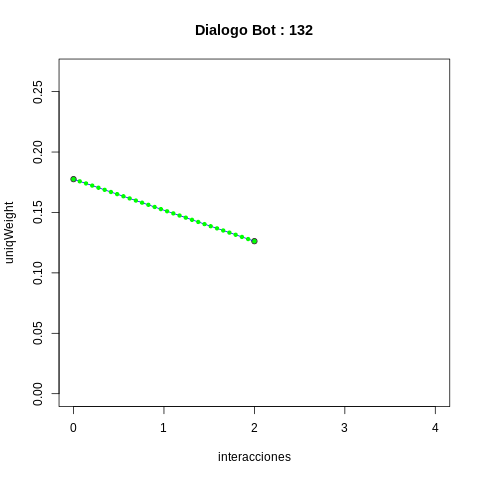

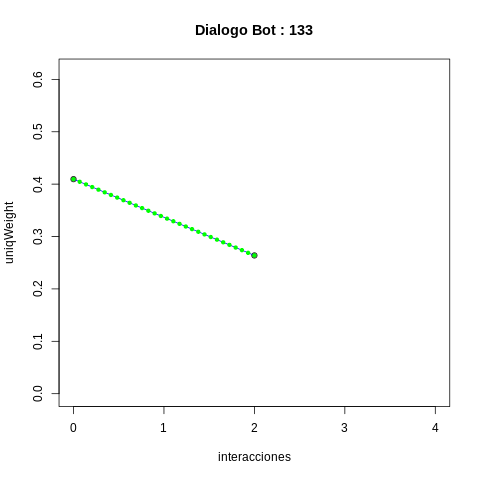

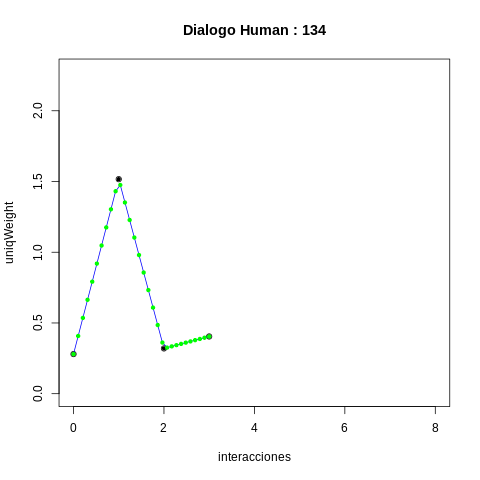

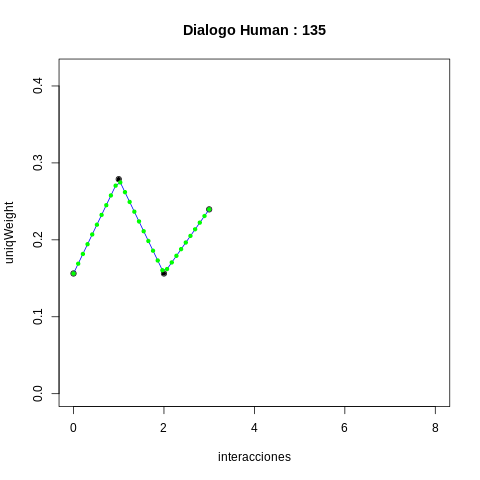

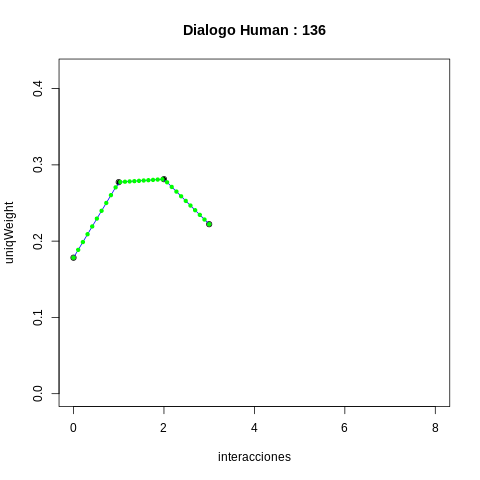

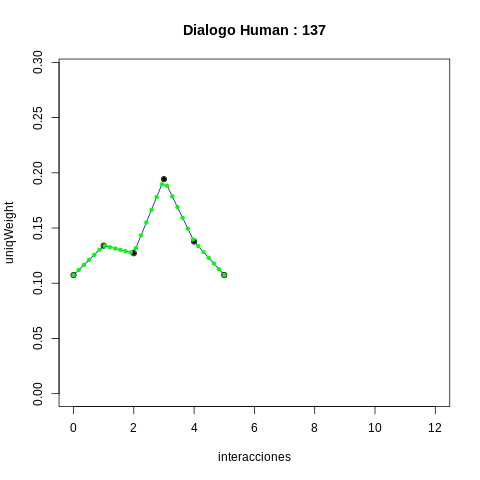

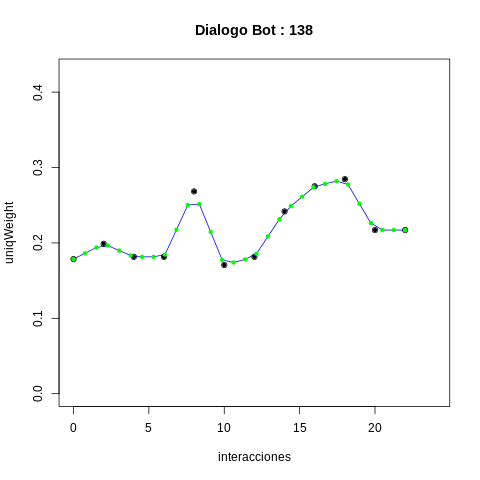

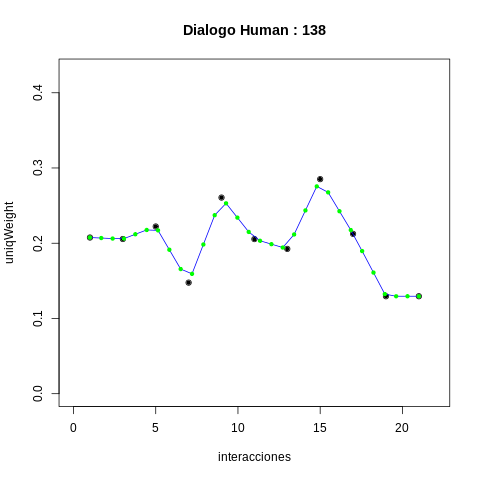

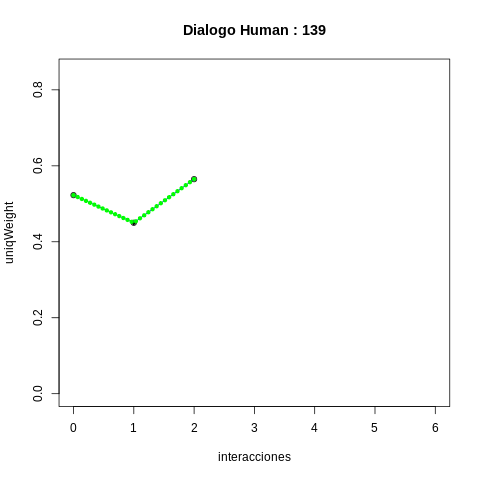

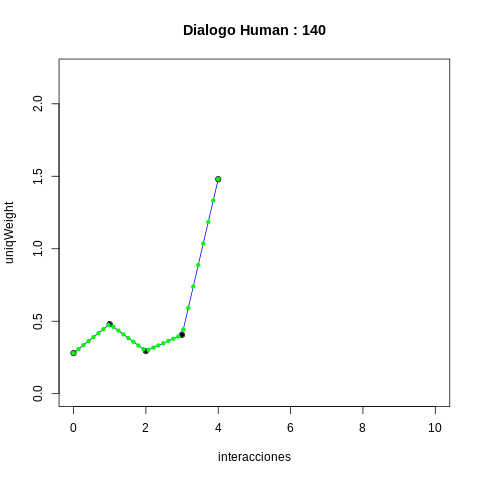

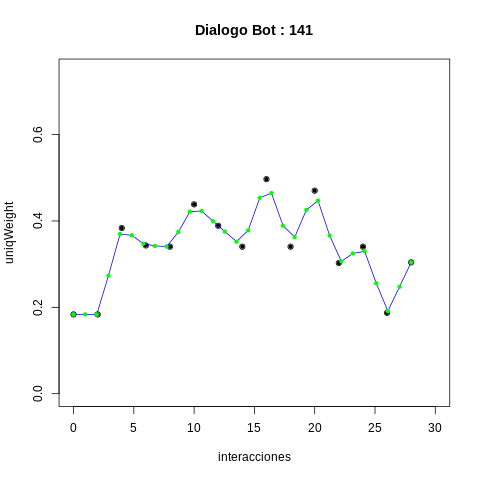

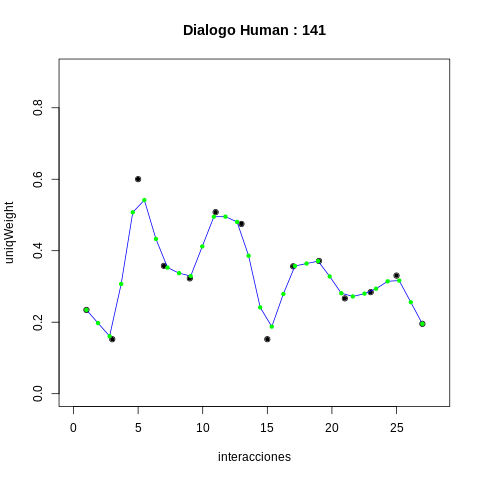

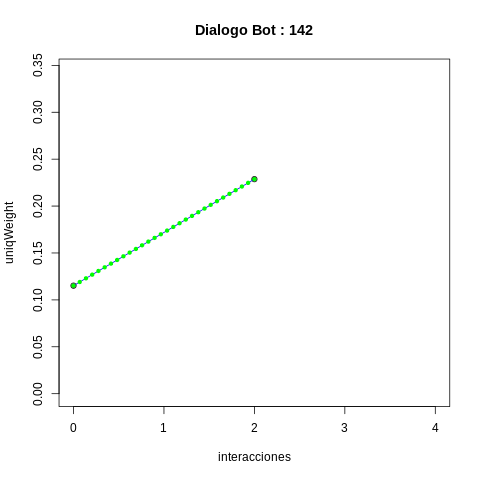

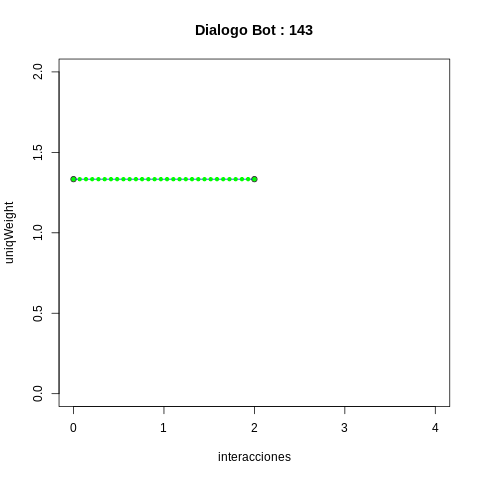

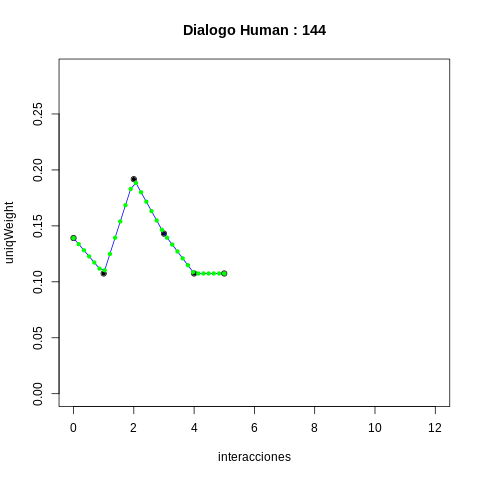

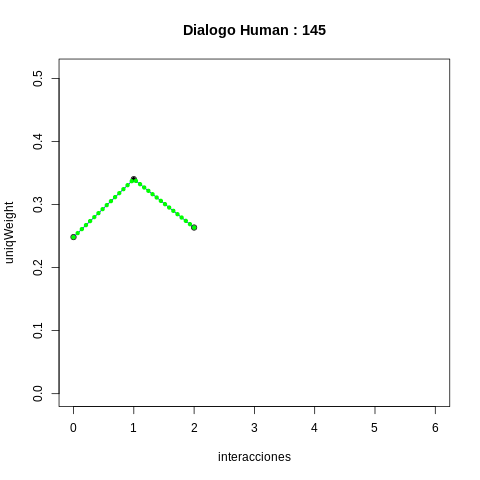

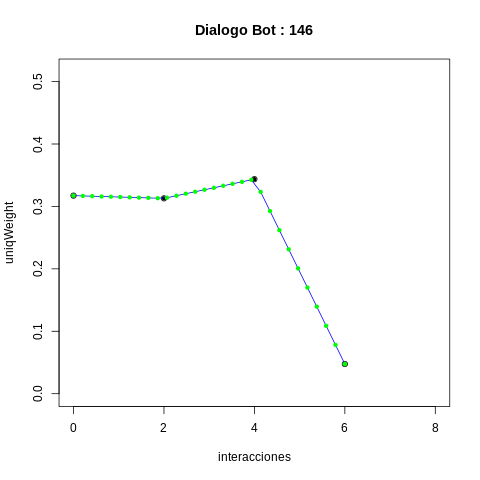

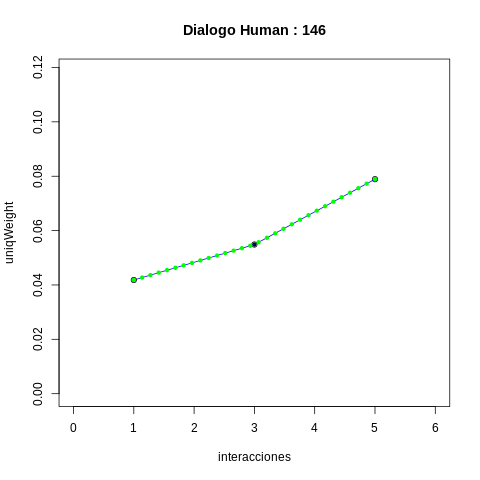

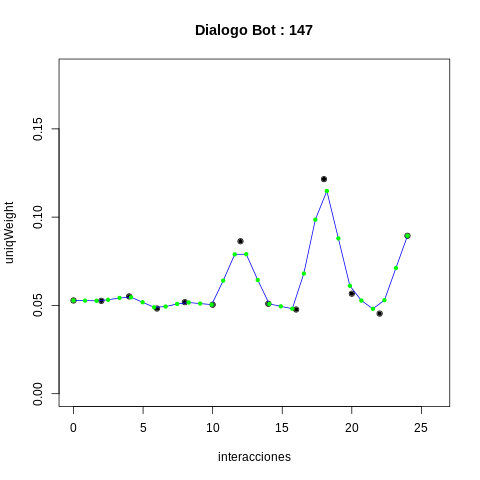

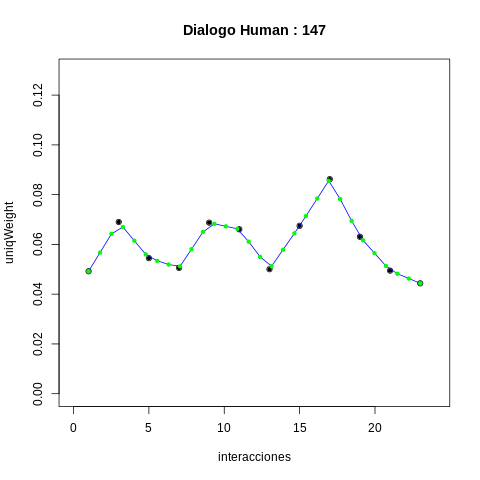

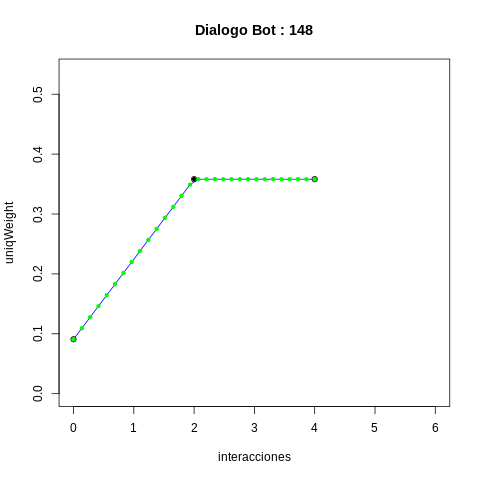

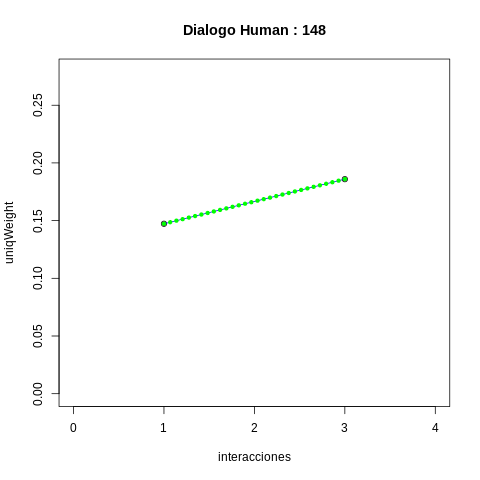

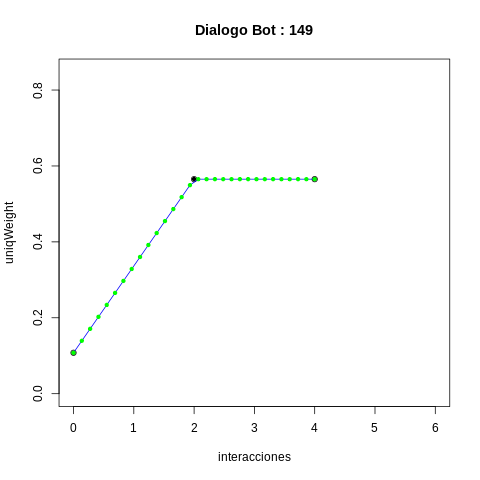

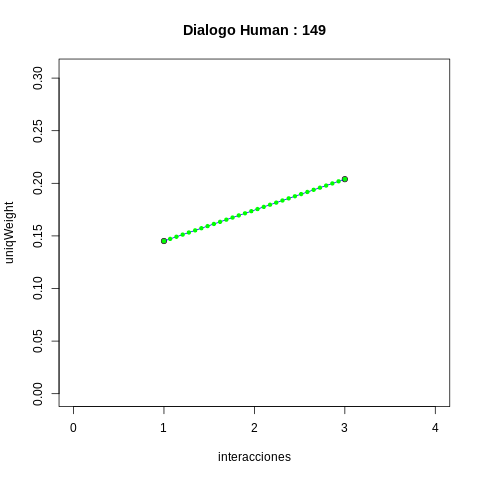

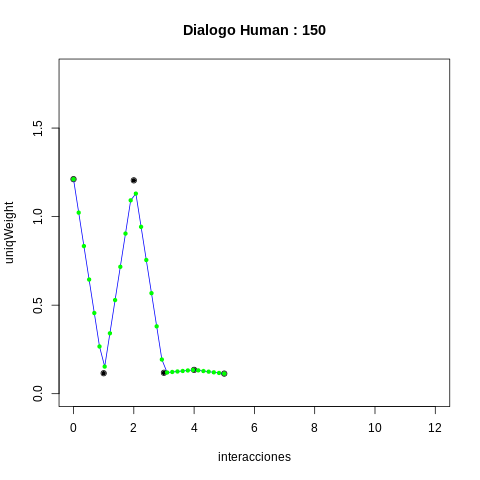

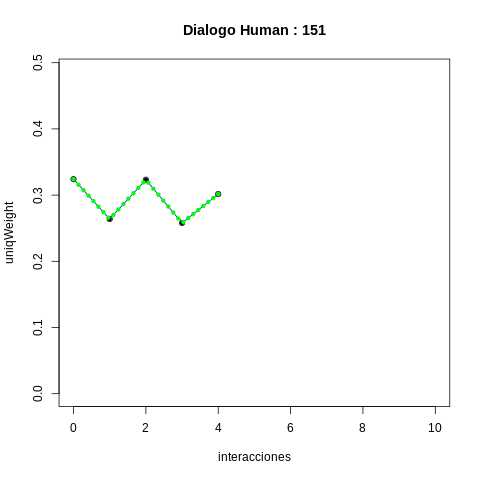

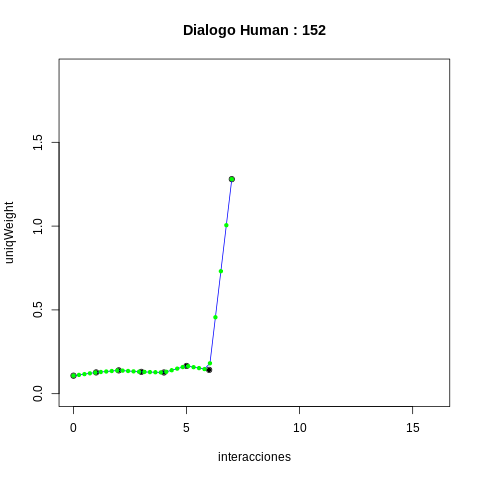

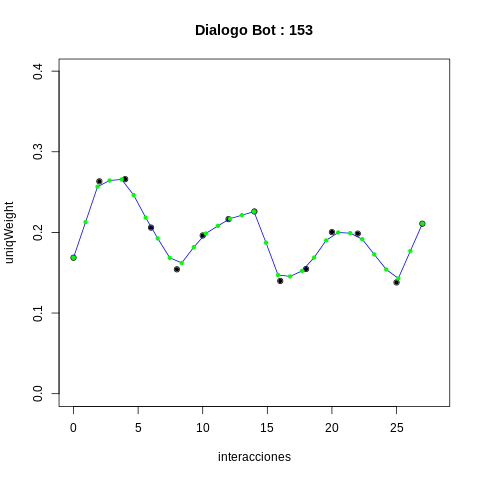

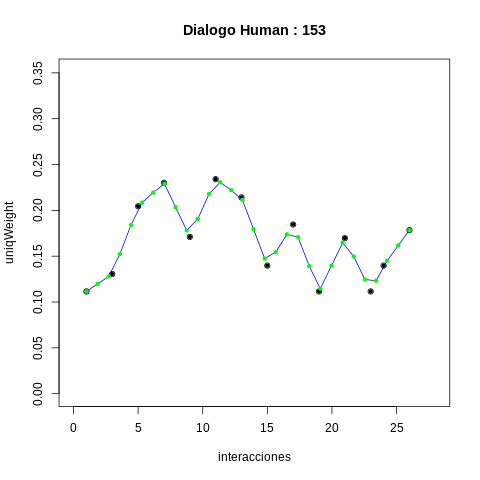

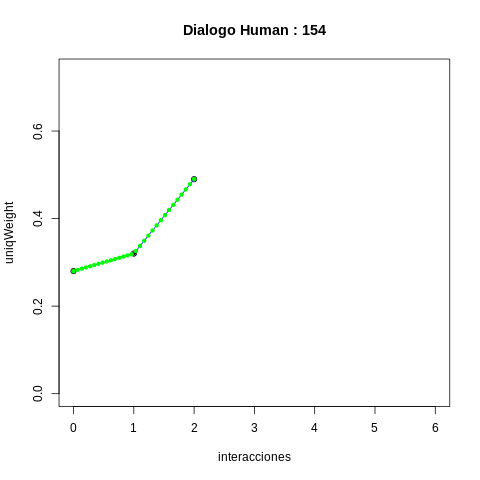

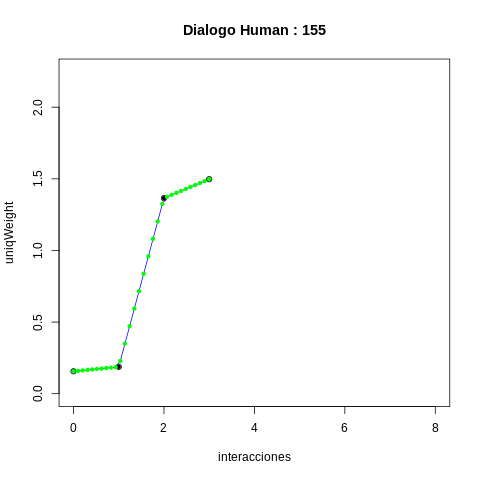

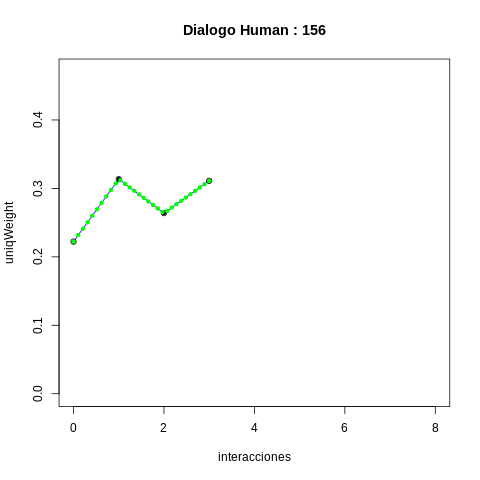

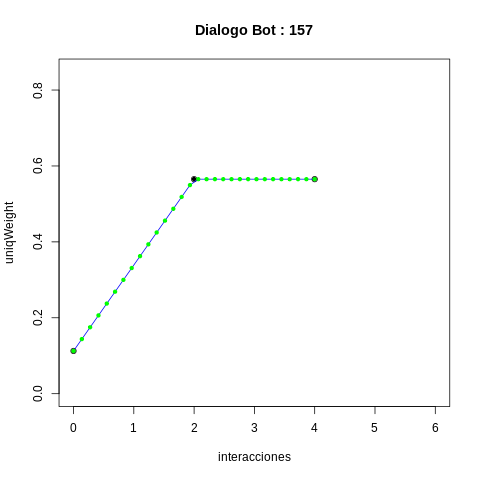

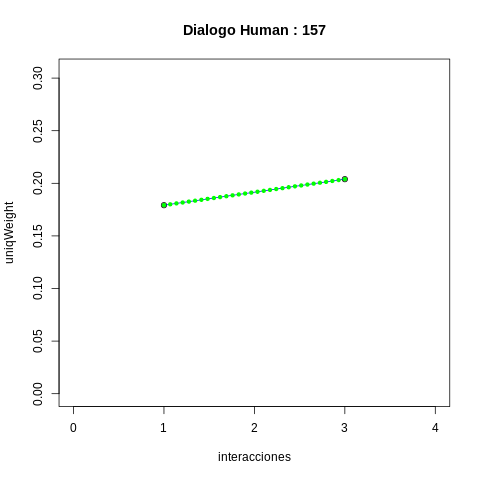

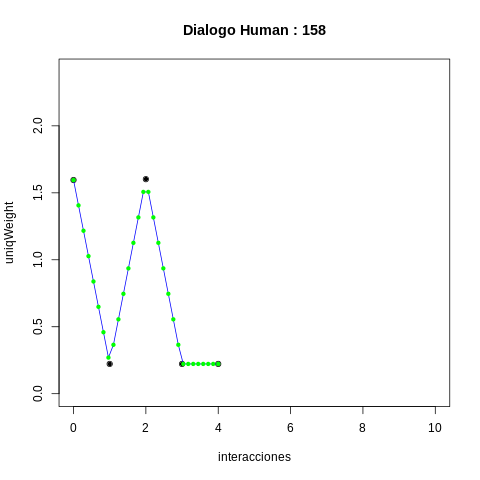

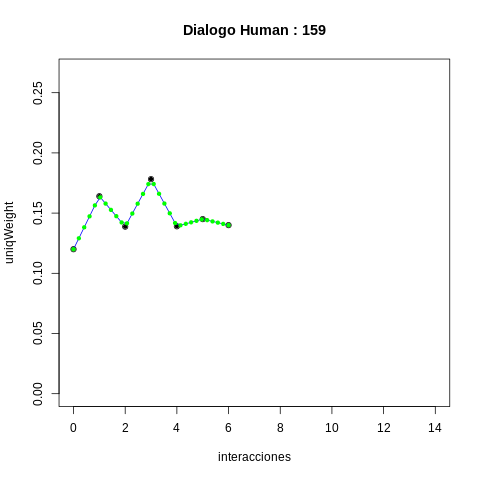

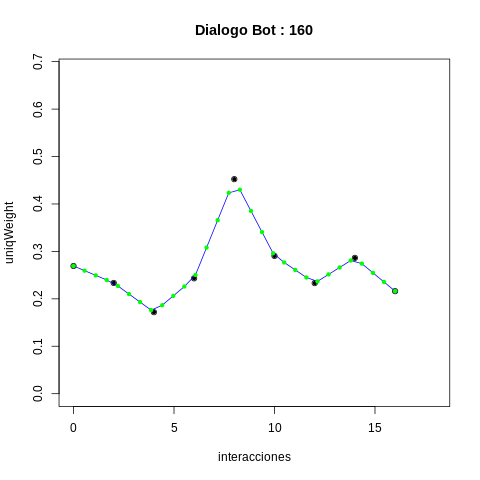

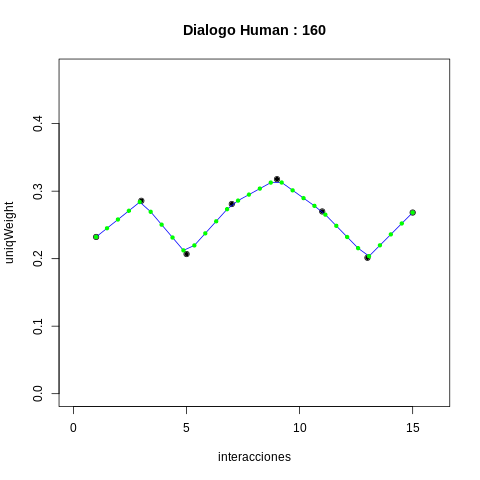

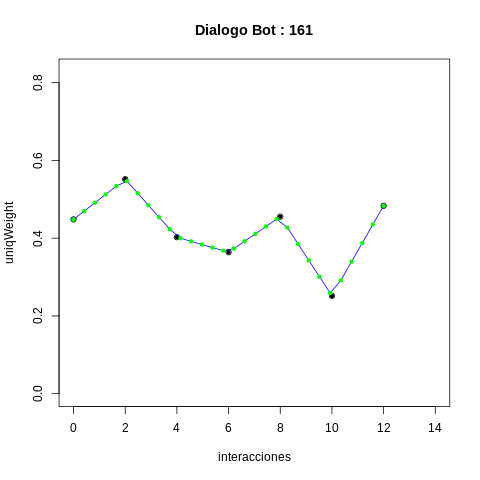

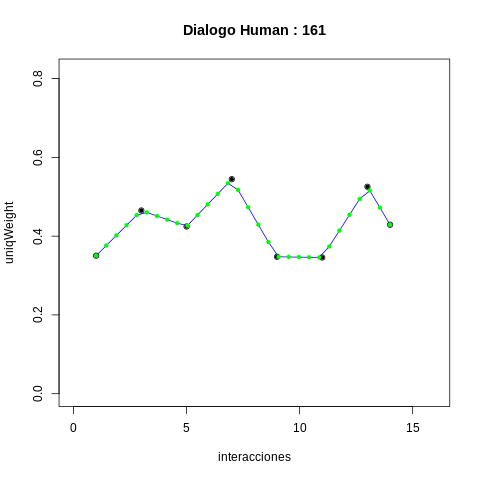

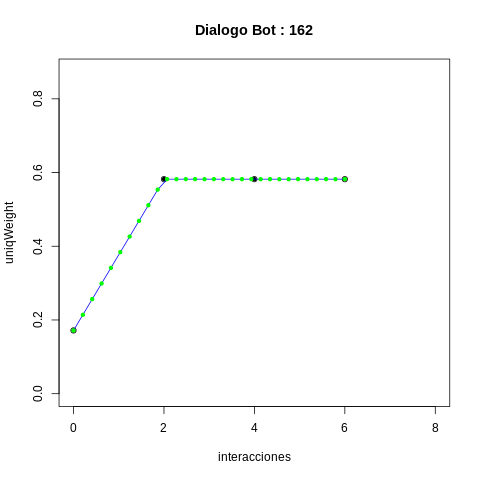

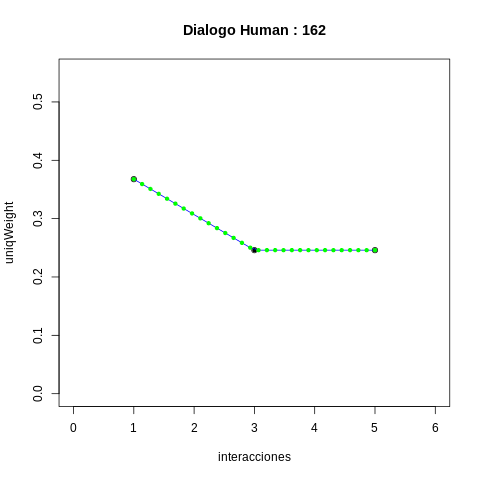

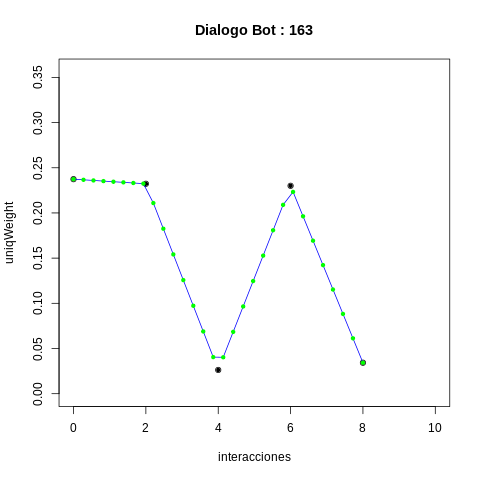

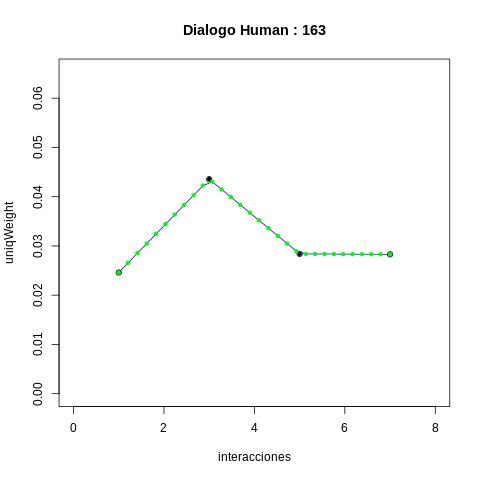

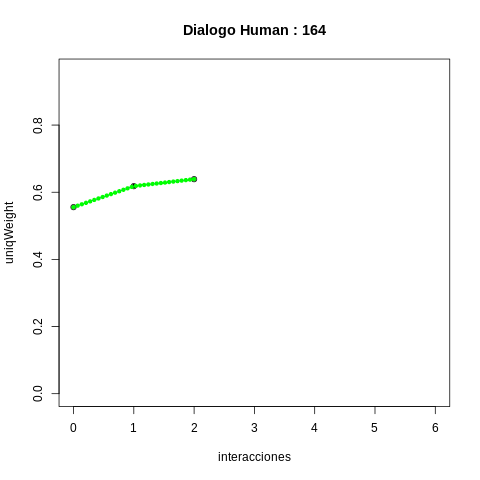

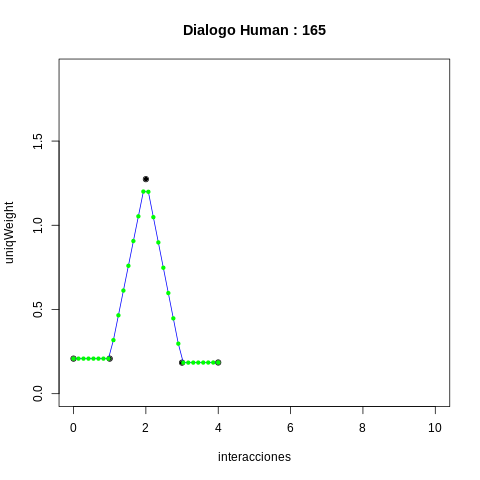

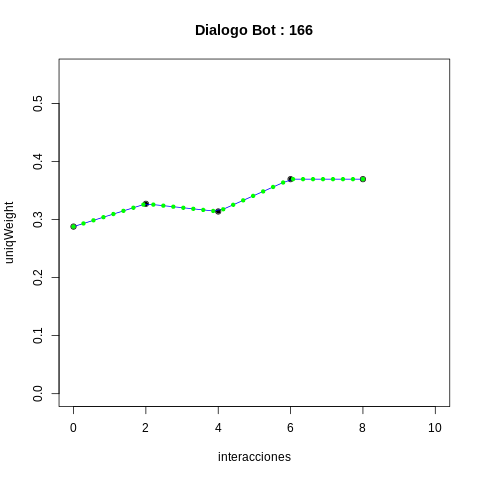

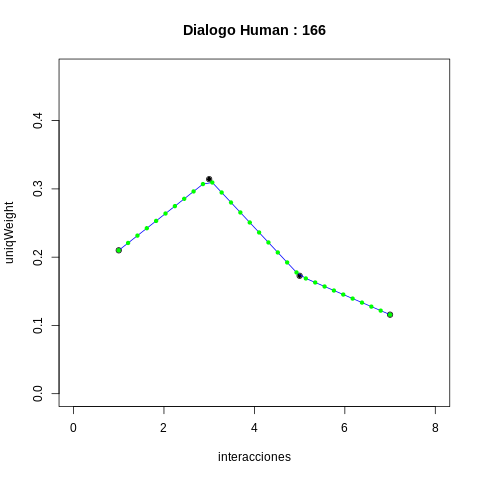

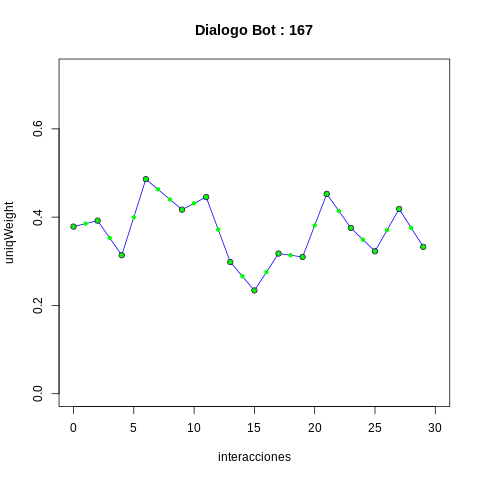

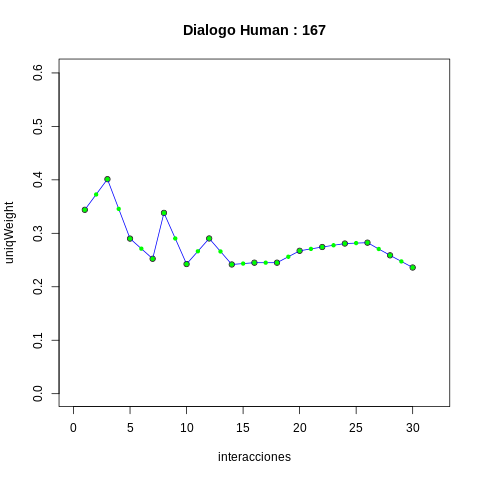

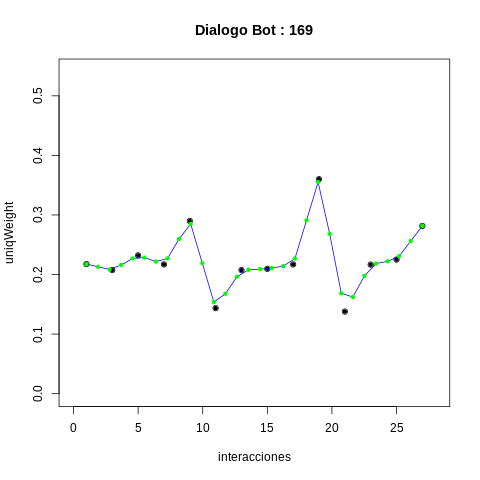

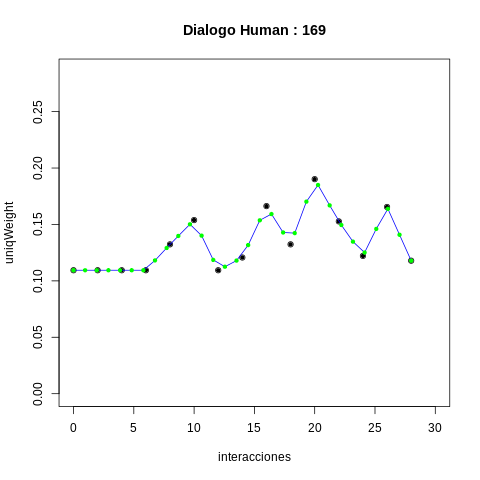

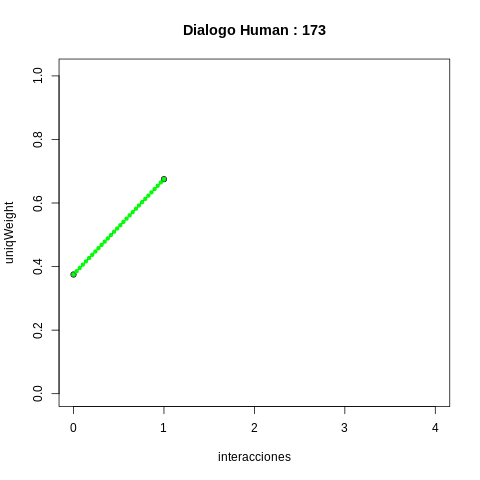

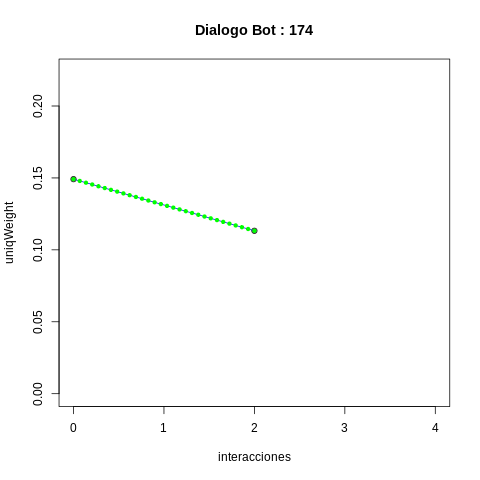

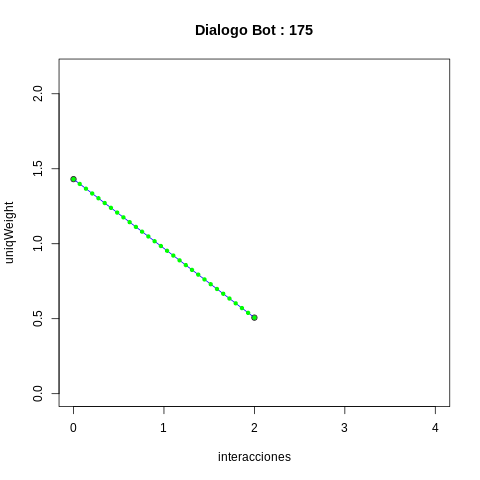

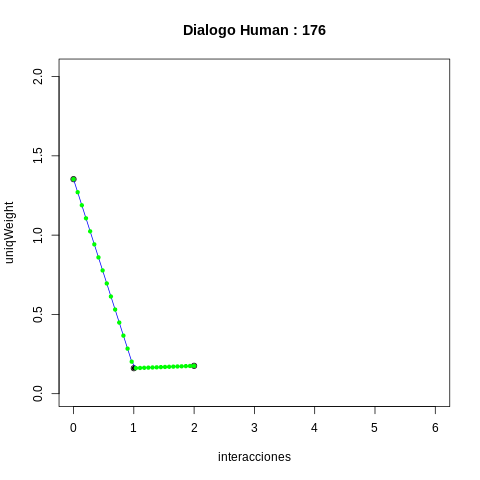

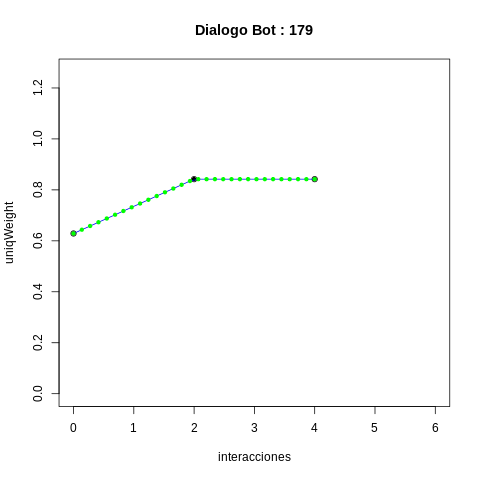

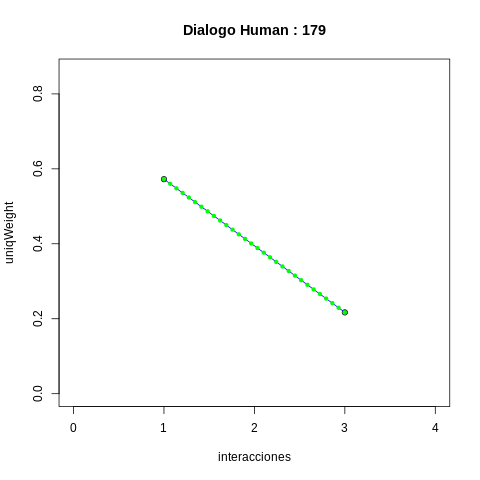

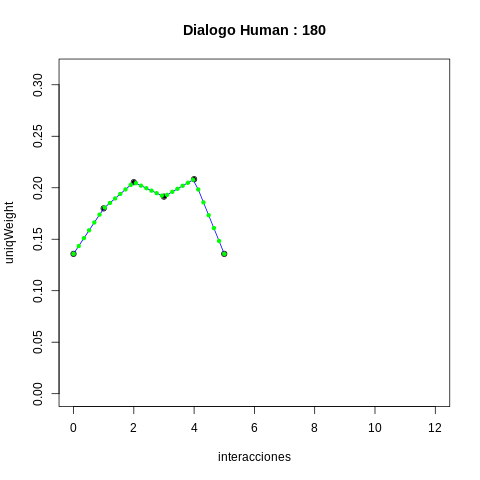

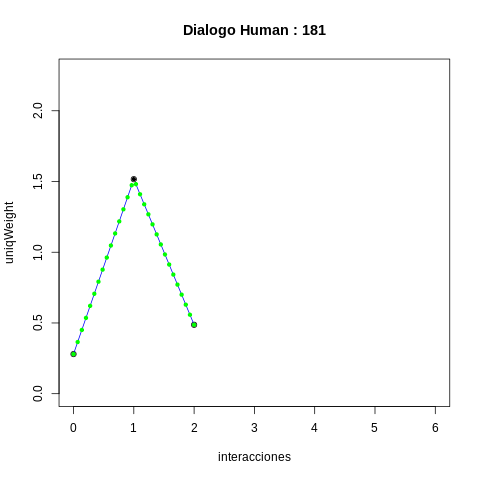

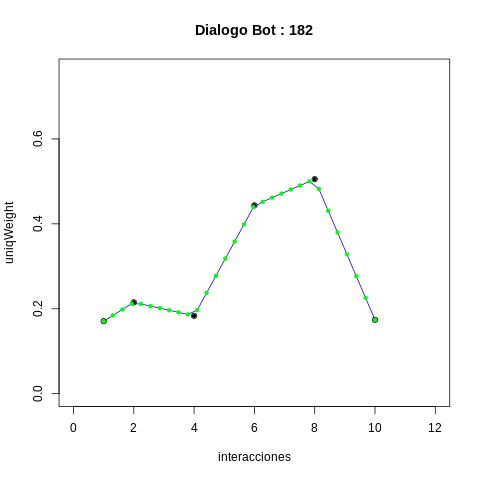

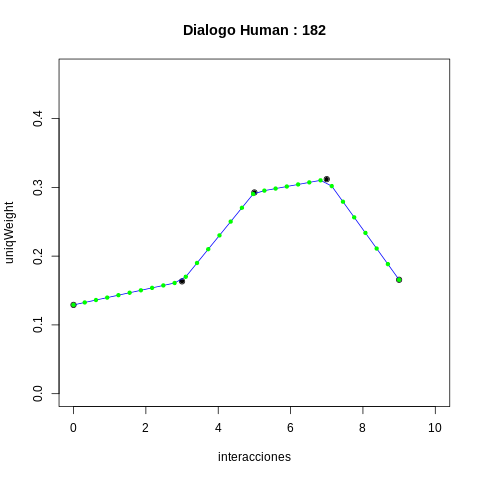

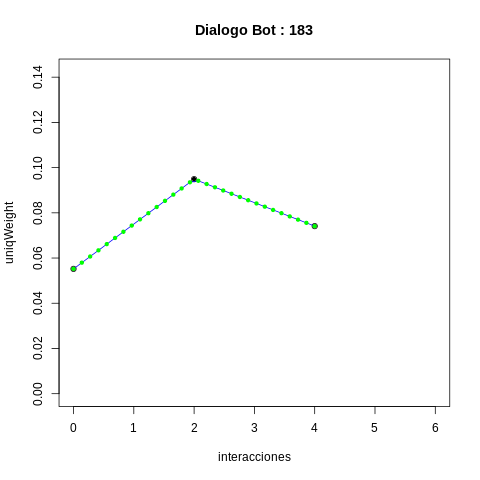

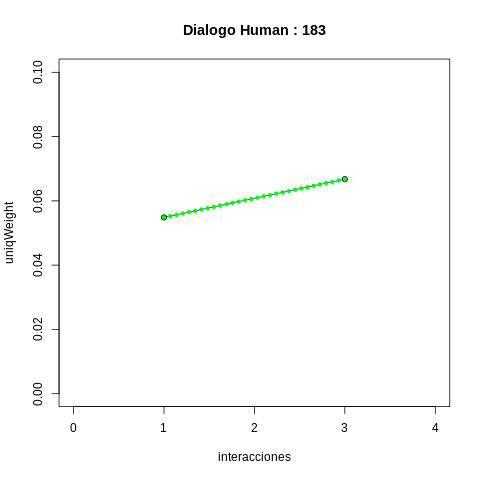

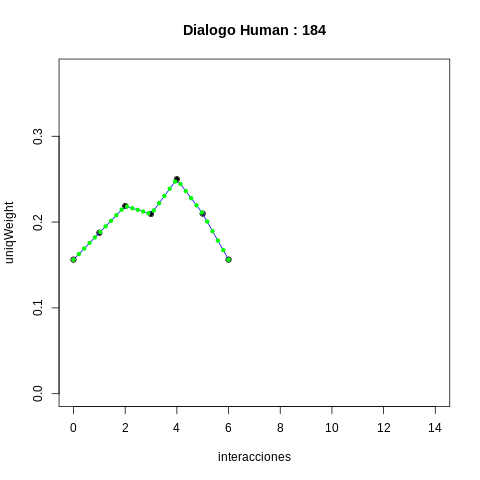

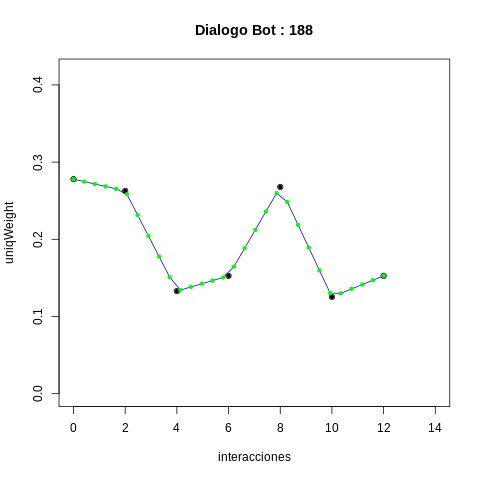

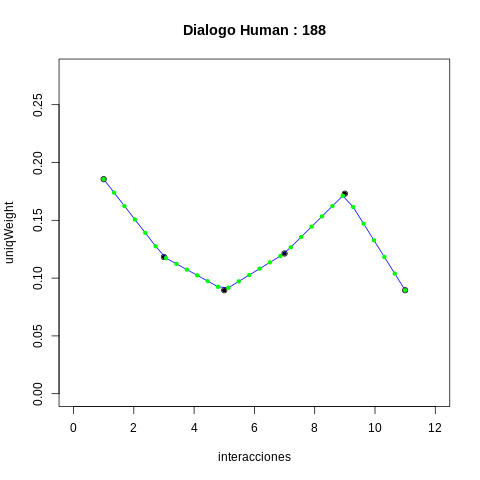

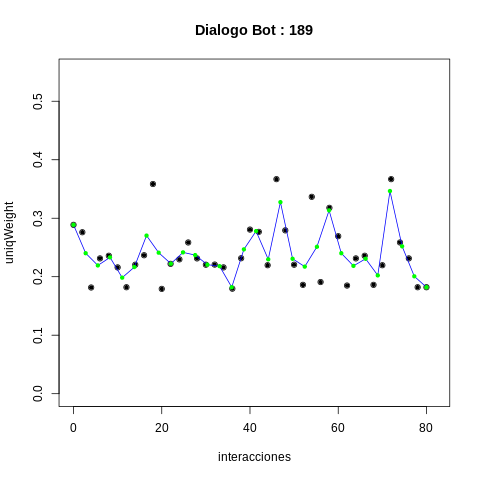

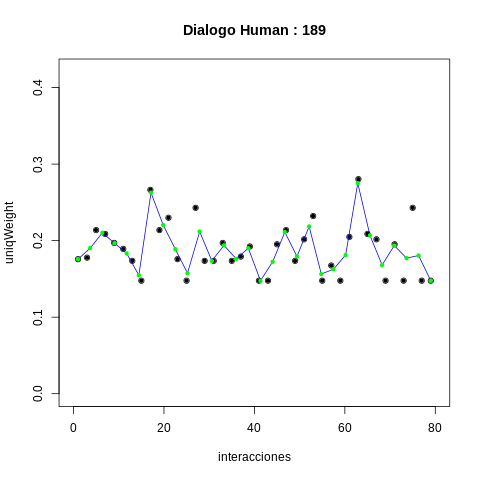

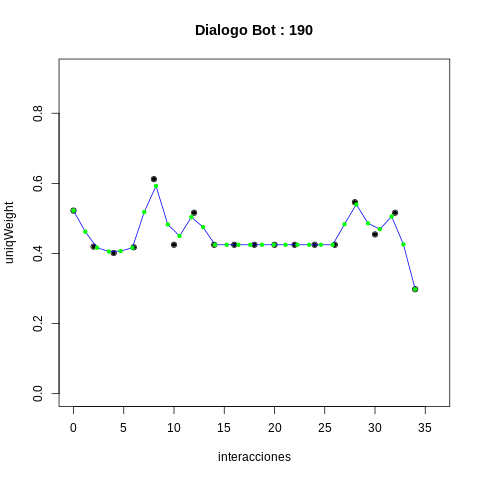

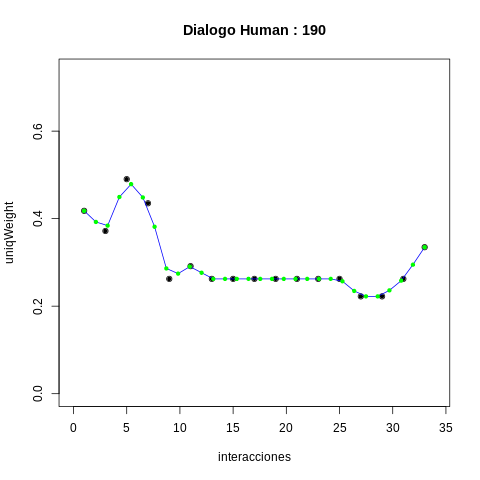

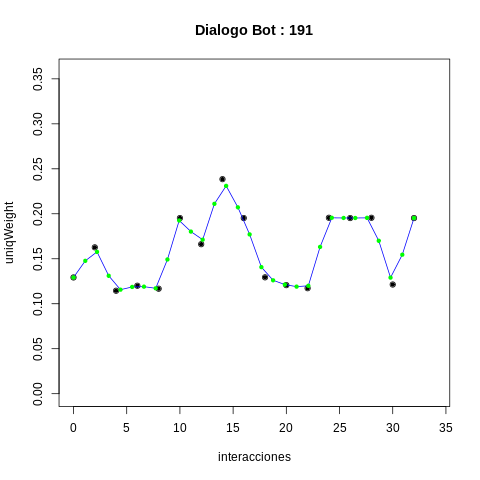

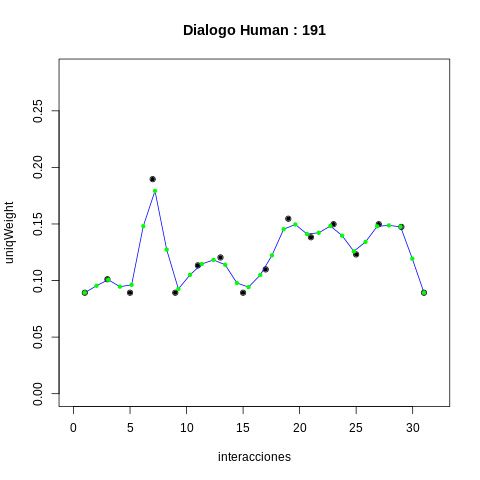

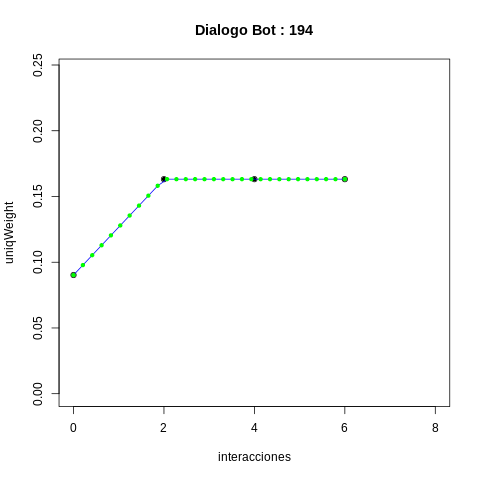

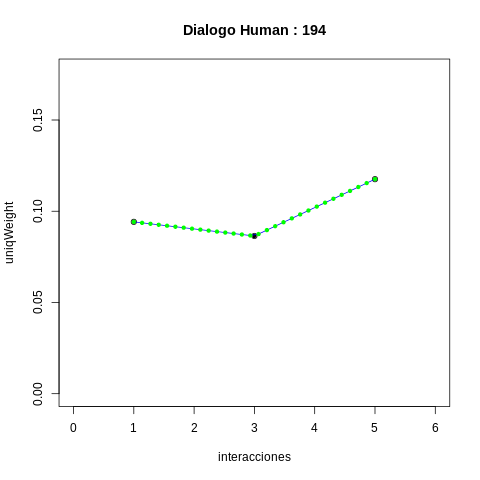

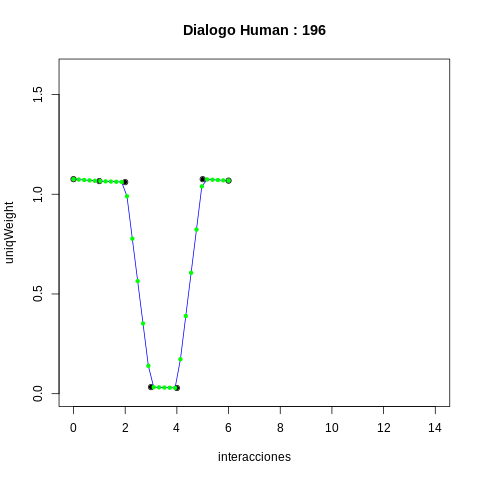

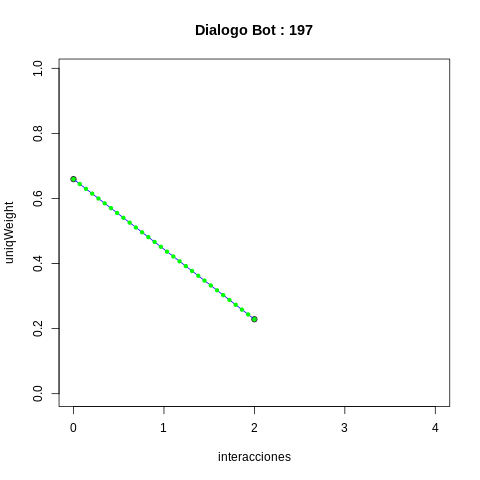

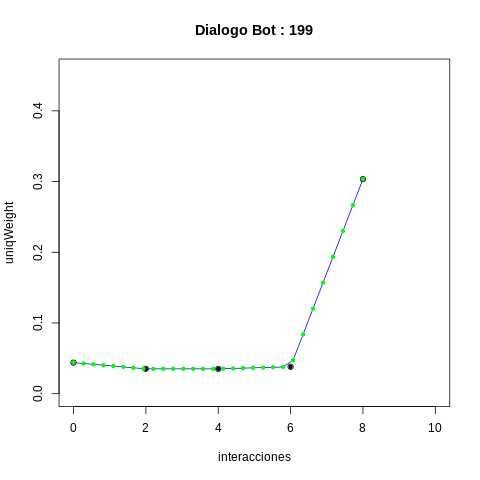

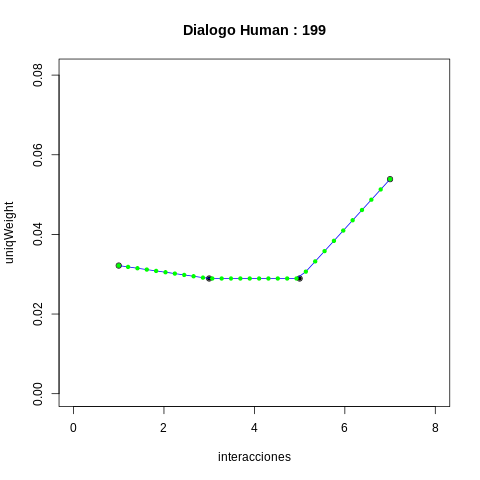

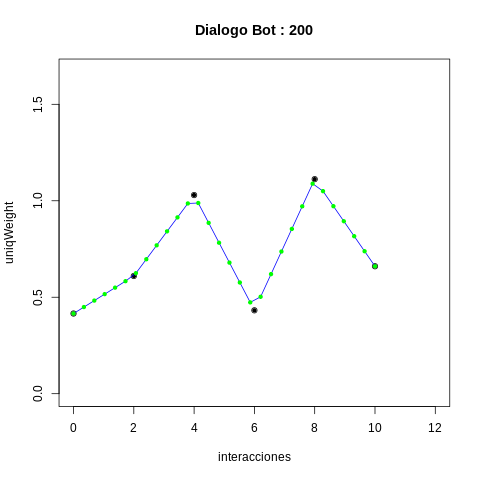

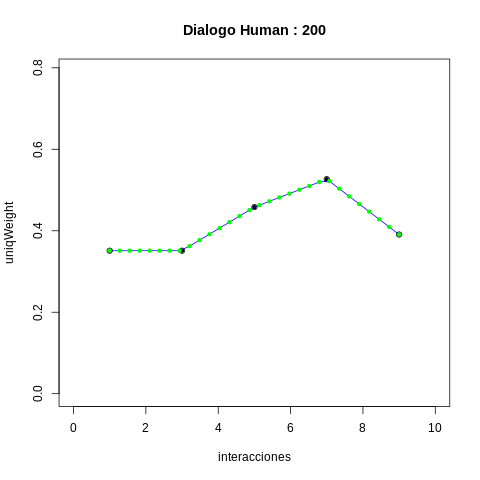

In [11]:
%%R
#En esta celda podemos revisar la grafica comparativa de los dialogos entre seres humanos y bots

#for (i in 1:length(list_dialog){
for (i in 101:200){
     dialogo=dfinterpolado_r[ dfinterpolado_r$dialog_id==list_dialog[i] & dfinterpolado_r$sender_class=="Bot",]
     if (length(dialogo$uniqWeight) > 1) {
      print(paste('Dialogo numero :',i)) 
      print(dialogo)
      N = length(dialogo$uniqWeight)
      maxy=max(dialogo$uniqWeight)
      print(paste('N =',N))
      NI=30
      uniqWeights = approx(dialogo$id, dialogo$uniqWeight, n=NI)
      plot(dialogo$id, dialogo$uniqWeight, type='p', main=paste('Dialogo Bot :',i), xlab='interacciones', ylab='uniqWeight', xlim=c(0,N*2), ylim=c(0,maxy*1.5))
      points(dialogo$id, dialogo$uniqWeight, pch=20, col='black')
      lines(uniqWeights$x, uniqWeights$y, col='blue')
      points(uniqWeights$x, uniqWeights$y, pch=20, col='green')

     }
     dialogo=dfinterpolado_r[ dfinterpolado_r$dialog_id==list_dialog[i] & dfinterpolado_r$sender_class=="Human",]
     if (length(dialogo$uniqWeight) > 1) {
      print(paste('Dialogo numero :',i)) 
      print(dialogo)
      N = length(dialogo$uniqWeight)
      maxy=max(dialogo$uniqWeight)
      print(paste('N =',N))
      NI=30
      uniqWeights = approx(dialogo$id, dialogo$uniqWeight, n=NI)
      plot(dialogo$id, dialogo$uniqWeight, type='p', main=paste('Dialogo Human :',i), xlab='interacciones', ylab='uniqWeight', xlim=c(0,N*2), ylim=c(0,maxy*1.5))
      points(dialogo$id, dialogo$uniqWeight, pch=20, col='black')
      lines(uniqWeights$x, uniqWeights$y, col='blue')
      points(uniqWeights$x, uniqWeights$y, pch=20, col='green')
     }
}

In [13]:
%%R
#En esta celda generamos el dataframe para lstm con todos los dialogos interpolados en 30

dfdialogoInterpolado30 <- data.frame()

for (i in 1:length(list_dialog)){
     dBot <- data.frame()
     dHuman <- data.frame()
     dfdialogoBot <- data.frame()
     dfdialogoHuman <- data.frame()
     currentDialog <- data.frame()
     b=0
     h=0
     flagDialog=0

     print(paste('Dialogo Numero :',i)) 

     dBot=dfinterpolado_r[ dfinterpolado_r$dialog_id==list_dialog[i] & dfinterpolado_r$sender_class=="Bot",]
     if (length(dBot$uniqWeight) > 1) {
      b=1
      NI=30
      uniqWeightsBot = approx(dBot$id, dBot$uniqWeight, n=NI)
      dfdialogoBot=as.data.frame(do.call(cbind, uniqWeightsBot))  

      colnames(dfdialogoBot)[1] <- "id"
      colnames(dfdialogoBot)[2] <- "uniqWeight"

      dfdialogoBot$dialog_id=list_dialog[i]
      dfdialogoBot$sender_class="Bot"

     }
     dHuman=dfinterpolado_r[ dfinterpolado_r$dialog_id==list_dialog[i] & dfinterpolado_r$sender_class=="Human",]
     if (length(dHuman$uniqWeight) > 1) {
      h=1
      NI=30
      uniqWeightsHuman = approx(dHuman$id, dHuman$uniqWeight, n=NI)
      dfdialogoHuman=as.data.frame(do.call(cbind, uniqWeightsHuman))  

      colnames(dfdialogoHuman)[1] <- "id"
      colnames(dfdialogoHuman)[2] <- "uniqWeight"

      dfdialogoHuman$dialog_id=list_dialog[i]
      dfdialogoHuman$sender_class="Human"

     }
     if (h > 0 & b>0) {
         currentDialog <- rbind(dfdialogoBot, dfdialogoHuman)
         flagDialog=1
     } else {
         if (h > 0) {
             currentDialog = dfdialogoHuman
             flagDialog=1
         }
         if (b > 0) {
             currentDialog = dfdialogoBot
             flagDialog=1
         }
     }
     if (flagDialog) {
         dfdialogoInterpolado30 <- rbind(dfdialogoInterpolado30, currentDialog)
     }
}

[1] "Dialogo Numero : 1"
[1] "Dialogo Numero : 2"
[1] "Dialogo Numero : 3"
[1] "Dialogo Numero : 4"
[1] "Dialogo Numero : 5"
[1] "Dialogo Numero : 6"
[1] "Dialogo Numero : 7"
[1] "Dialogo Numero : 8"
[1] "Dialogo Numero : 9"
[1] "Dialogo Numero : 10"
[1] "Dialogo Numero : 11"
[1] "Dialogo Numero : 12"
[1] "Dialogo Numero : 13"
[1] "Dialogo Numero : 14"
[1] "Dialogo Numero : 15"
[1] "Dialogo Numero : 16"
[1] "Dialogo Numero : 17"
[1] "Dialogo Numero : 18"
[1] "Dialogo Numero : 19"
[1] "Dialogo Numero : 20"
[1] "Dialogo Numero : 21"
[1] "Dialogo Numero : 22"
[1] "Dialogo Numero : 23"
[1] "Dialogo Numero : 24"
[1] "Dialogo Numero : 25"
[1] "Dialogo Numero : 26"
[1] "Dialogo Numero : 27"
[1] "Dialogo Numero : 28"
[1] "Dialogo Numero : 29"
[1] "Dialogo Numero : 30"
[1] "Dialogo Numero : 31"
[1] "Dialogo Numero : 32"
[1] "Dialogo Numero : 33"
[1] "Dialogo Numero : 34"
[1] "Dialogo Numero : 35"
[1] "Dialogo Numero : 36"
[1] "Dialogo Numero : 37"
[1] "Dialogo Numero : 38"
[1] "Dialogo Numero :

In [14]:
%%R
nrow(dfdialogoInterpolado30)

[1] 137010


In [15]:
%%R

write.csv(dfdialogoInterpolado30,'/gdrive/My Drive/dfdialogoInterpoladoApprox30.csv', row.names = FALSE)